# LLM4기 Study Text-To-SQL Langchain

튜토리얼 참고 : https://python.langchain.com/docs/tutorials/sql_qa

데이터베이스 참고 : https://www.sqlitetutorial.net/sqlite-sample-database/

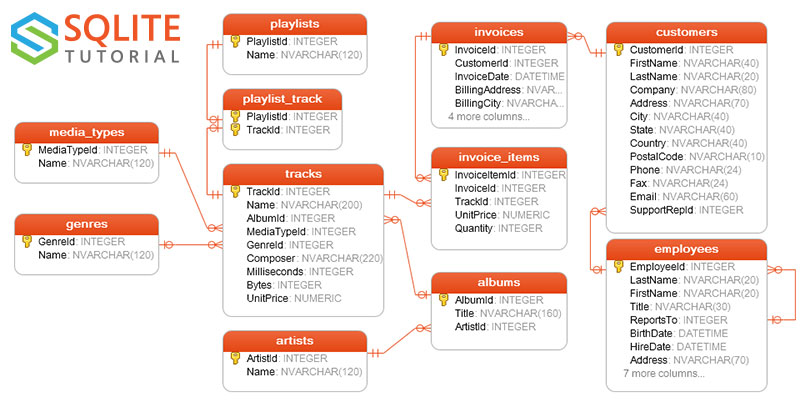

In [10]:
# db 다운로드
!wget https://www.sqlitetutorial.net/wp-content/uploads/2018/03/chinook.zip -O chinook.zip

--2025-03-31 11:21:16--  https://www.sqlitetutorial.net/wp-content/uploads/2018/03/chinook.zip
Resolving www.sqlitetutorial.net (www.sqlitetutorial.net)... 104.21.30.141, 172.67.172.250, 2606:4700:3037::6815:1e8d, ...
Connecting to www.sqlitetutorial.net (www.sqlitetutorial.net)|104.21.30.141|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 305596 (298K) [application/zip]
Saving to: ‘chinook.zip’

chinook.zip         100%[===================>] 298.43K  --.-KB/s    in 0.03s   

2025-03-31 11:21:16 (8.91 MB/s) - ‘chinook.zip’ saved [305596/305596]



In [13]:
# db 압축해제
!unzip chinook.zip

Archive:  chinook.zip
replace chinook.db? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [12]:
# 라이브러리 설치
!pip install --upgrade --quiet  langchain langchain-community langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.1/420.1 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 27.6 MB/s eta 0:00:00


In [15]:
# OpenAI API Key
OPENAI_KEY = ""

In [62]:
# db 쿼리 테스트

from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///chinook.db")
# print(db.dialect)
# print(db.get_usable_table_names())
# db.run("SELECT * FROM artists LIMIT 10;")
db.run("SELECT City FROM customers LIMIT 30;")
# db.run("select count(customerId) from customers")
# db.run("SELECT * FROM invoices LIMIT 10;")

"[('São José dos Campos',), ('Stuttgart',), ('Montréal',), ('Oslo',), ('Prague',), ('Prague',), ('Vienne',), ('Brussels',), ('Copenhagen',), ('São Paulo',), ('São Paulo',), ('Rio de Janeiro',), ('Brasília',), ('Edmonton',), ('Vancouver',), ('Mountain View',), ('Redmond',), ('New York',), ('Cupertino',), ('Mountain View',), ('Reno',), ('Orlando',), ('Boston',), ('Chicago',), ('Madison',), ('Fort Worth',), ('Tucson',), ('Salt Lake City',), ('Toronto',), ('Ottawa',)]"

In [46]:
from langchain.chains import create_sql_query_chain
from langchain_openai import ChatOpenAI

model = "gpt-3.5-turbo"
# model = "gpt-4o-mini"
# model = "gpt-4o"

llm = ChatOpenAI(model=model, temperature=0, openai_api_key=OPENAI_KEY)
chain = create_sql_query_chain(llm, db)


In [52]:
response = chain.invoke({"question": "모든 거래처수를 알려줘"})
print("생성된 SQL:\n" + response)

result = db.run(response)
print("\n결과:\n" + result)

생성된 SQL:
SELECT COUNT("CustomerId") AS TotalCustomers
FROM customers

결과:
[(59,)]


In [53]:
response = chain.invoke({"question": "브라질의 모든 거래처수를 알려줘"})
print("생성된 SQL:\n" + response)

result = db.run(response)
print("\n결과:\n" + result)

생성된 SQL:
SELECT COUNT("CustomerId") AS "TotalCustomersInBrazil"
FROM customers
WHERE "Country" = 'Brazil'

결과:
[(5,)]


In [66]:
response = chain.invoke({"question": "미국의 거래처 직원들의 생일을 알려줘"})
print("생성된 SQL:\n" + response)

result = db.run(response)
print("\n결과:\n" + result)

생성된 SQL:
SELECT c."FirstName", c."LastName", e."BirthDate"
FROM customers c
JOIN employees e ON c."SupportRepId" = e."EmployeeId"
WHERE c."Country" = 'USA'
ORDER BY e."BirthDate" ASC
LIMIT 5;

결과:
[('Frank', 'Harris', '1947-09-19 00:00:00'), ('Dan', 'Miller', '1947-09-19 00:00:00'), ('Heather', 'Leacock', '1947-09-19 00:00:00'), ('John', 'Gordon', '1947-09-19 00:00:00'), ('Richard', 'Cunningham', '1947-09-19 00:00:00')]


In [80]:
response = chain.invoke({"question": "미국 거래처 직원들의 영수증 합계를 알려줘"})
print("생성된 SQL:\n" + response)

result = db.run(response)
print("\n결과:\n" + result)

생성된 SQL:
SELECT e."FirstName" || ' ' || e."LastName" AS "EmployeeName", SUM(i."Total") AS "TotalSales"
FROM employees e
JOIN customers c ON e."EmployeeId" = c."SupportRepId"
JOIN invoices i ON c."CustomerId" = i."CustomerId"
GROUP BY e."EmployeeId"
ORDER BY "TotalSales" DESC
LIMIT 5;

결과:
[('Jane Peacock', 833.0400000000013), ('Margaret Park', 775.4000000000011), ('Steve Johnson', 720.160000000001)]
